In [1]:
import numpy as np
import pandas as pd
import os, gc
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from helper import additive_trend_additive_seasonality_data, additive_trend_and_multiplicative_seasonality_data, multiplicative_trend_and_additive_seasonality_data, multiplicative_trend_and_multiplicative_seasonality_data

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)

## Additive vs Multiplicative

<hr>

```python
# additive
y(t) = Level + Trend + Seasonality + Noise

# multiplicative
y(t) = Level * Trend * Seasonality * Noise
```

In [2]:
## --------------------------------------------------------------------------------------------------------------------- ##

### Trend

- An <b>additive trend</b> indicates a <b>linear trend</b>

- A <b>multiplicative trend</b> indicates a <b>non-linear trend (curved trend line)</b>

<hr>

### Seasonal

- An <b>additive seasonality</b> indicates the <b>same frequency (width) and amplitude (height)</b> of seasonal cycles.

- A <b>multiplicative seasonality</b> indicates <b>increasing/decreasing frequency (width) and/or amplitude (height)</b> of seasonal cycles.

In [3]:
atas = additive_trend_additive_seasonality_data()
atms = additive_trend_and_multiplicative_seasonality_data()
mtas = multiplicative_trend_and_additive_seasonality_data()
mtms = multiplicative_trend_and_multiplicative_seasonality_data()

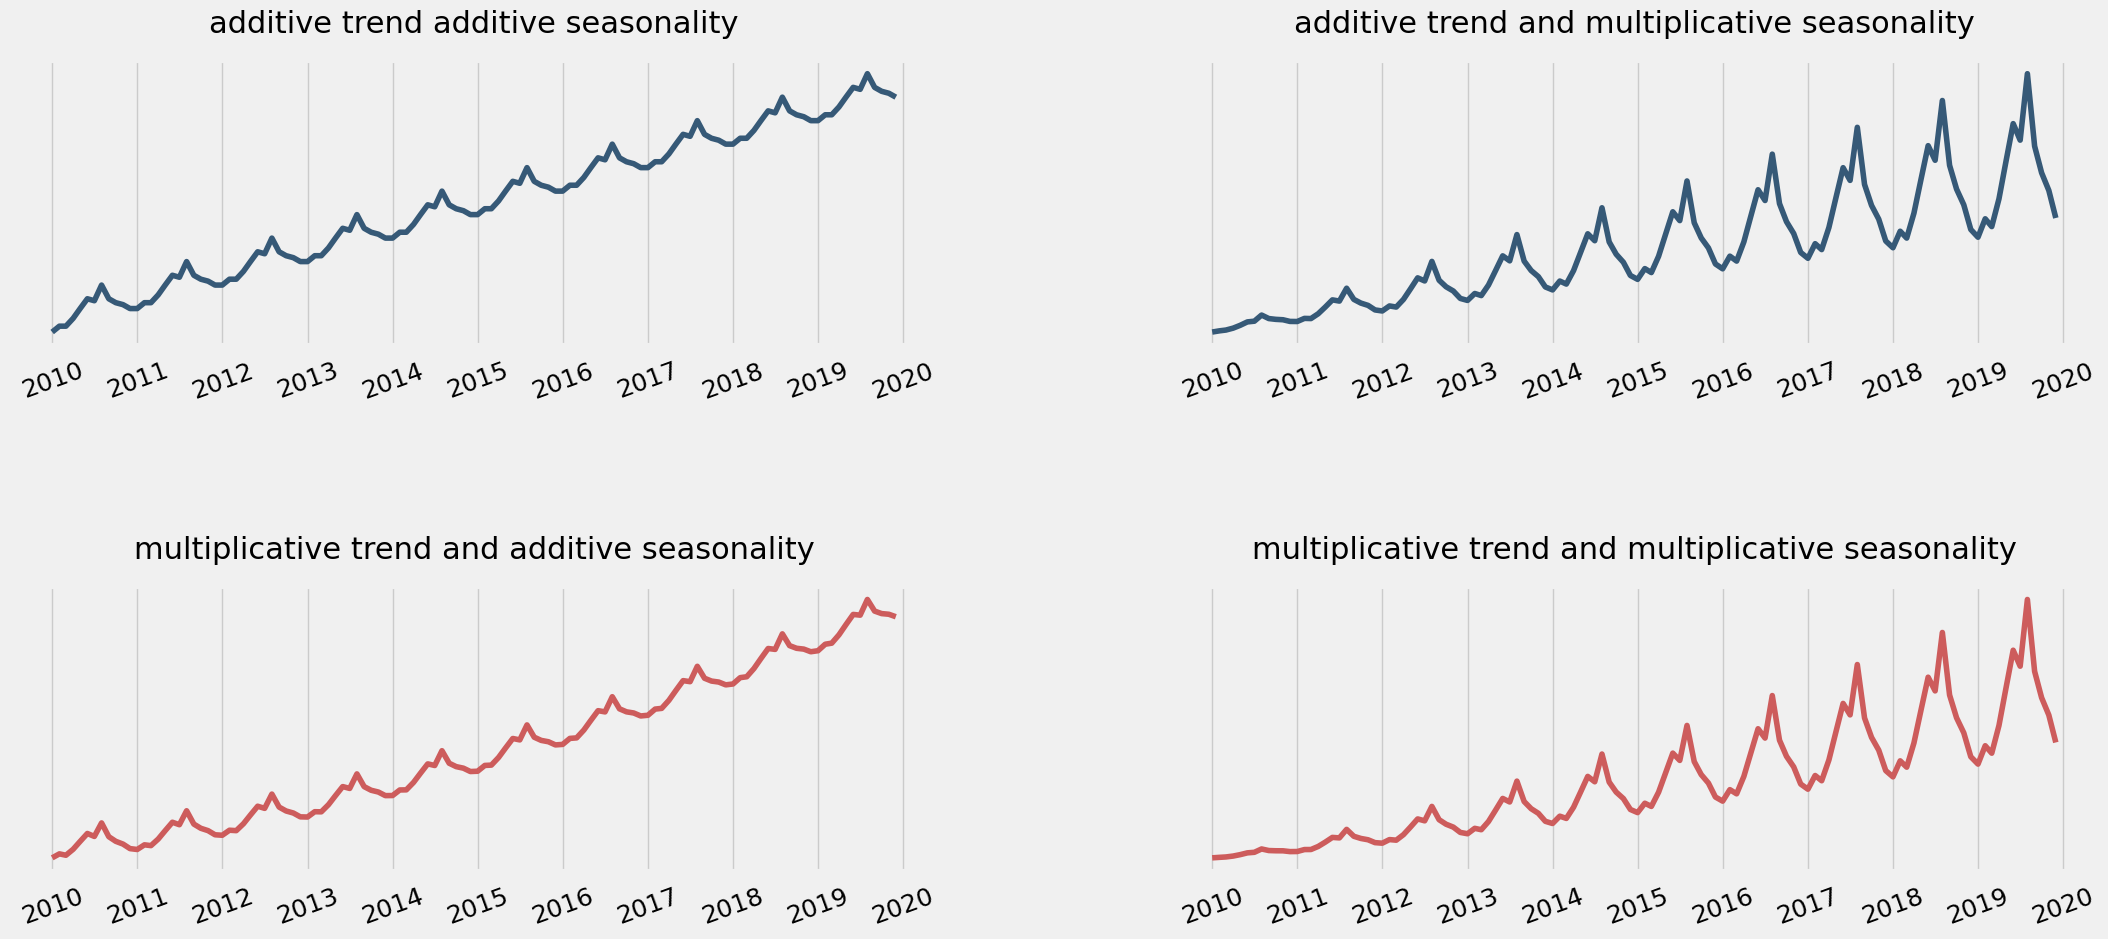

In [4]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(24, 10))

ax.ravel()[0].plot(atas, color='#365977')
ax.ravel()[0].set_title('additive trend additive seasonality', pad=20, fontsize=22)
ax.ravel()[0].set_yticks([])
ax.ravel()[0].tick_params(axis='x', which='major', labelsize=18, pad=10, rotation=20)

ax.ravel()[1].plot(atms, color='#365977')
ax.ravel()[1].set_title('additive trend and multiplicative seasonality', pad=20, fontsize=22)
ax.ravel()[1].set_yticks([])
ax.ravel()[1].tick_params(axis='x', which='major', labelsize=18, pad=10, rotation=20)

ax.ravel()[2].plot(mtas, color='indianred')
ax.ravel()[2].set_title('multiplicative trend and additive seasonality', pad=20, fontsize=22)
ax.ravel()[2].set_yticks([])
ax.ravel()[2].tick_params(axis='x', which='major', labelsize=18, pad=10, rotation=20)

ax.ravel()[3].plot(mtms, color='indianred')
ax.ravel()[3].set_title('multiplicative trend and multiplicative seasonality', pad=20, fontsize=22)
ax.ravel()[3].set_yticks([])
ax.ravel()[3].tick_params(axis='x', which='major', labelsize=18, pad=10, rotation=20)

plt.subplots_adjust(hspace = 0.85, wspace=.25)
plt.show()

## Be Carefull

<div class="alert alert-success"> <b>Looks the same but actually it's not<br><br>You can see how the trend in red color is slightly curved (non-linear), because it's multiplicative</b> </div>

source: [medium](https://towardsdatascience.com/time-series-from-scratch-decomposing-time-series-data-7b7ad0c30fe7)

In [5]:
## --------------------------------------------------------------------------------------------------------------------- ##

## Time Series Decomposition

<hr>

Time series data can exhibit a variety of patterns, and it is often helpful to split a time series into <b>level, trend, seasonality, and residual</b>, each representing an underlying pattern category.

<br>

When forecasting, it is advantageous to use a seasonally-adjusted time series, which is just a time series with the seasonal component removed.

This allows a forecaster to focus on predicting the general trend of the data.

In [6]:
# AirPassengers dataset
# source: https://www.kaggle.com/datasets/rakannimer/air-passengers
df = pd.read_csv('AirPassengers.csv')

df.columns = ['month', 'num_passengers']
df = df.set_index('month')

In [7]:
df.head(3)

,num_passengers
month,
1949-01,112
1949-02,118
1949-03,132


In [8]:
## --------------------------------------------------------------------------------------------------------------------- ##

## Common Approach

```python
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_decompose(series, model='additive') # multiplicative
```

<div class="alert alert-danger"> <b>While classical decomposition is still widely used, it is not recommended, as there are now several much better methods</b> </div>

In [9]:
result = seasonal_decompose(df['num_passengers'], model='multiplicative',  period=12) # the frequency of our data is monthly, 12 is yearly seasonality

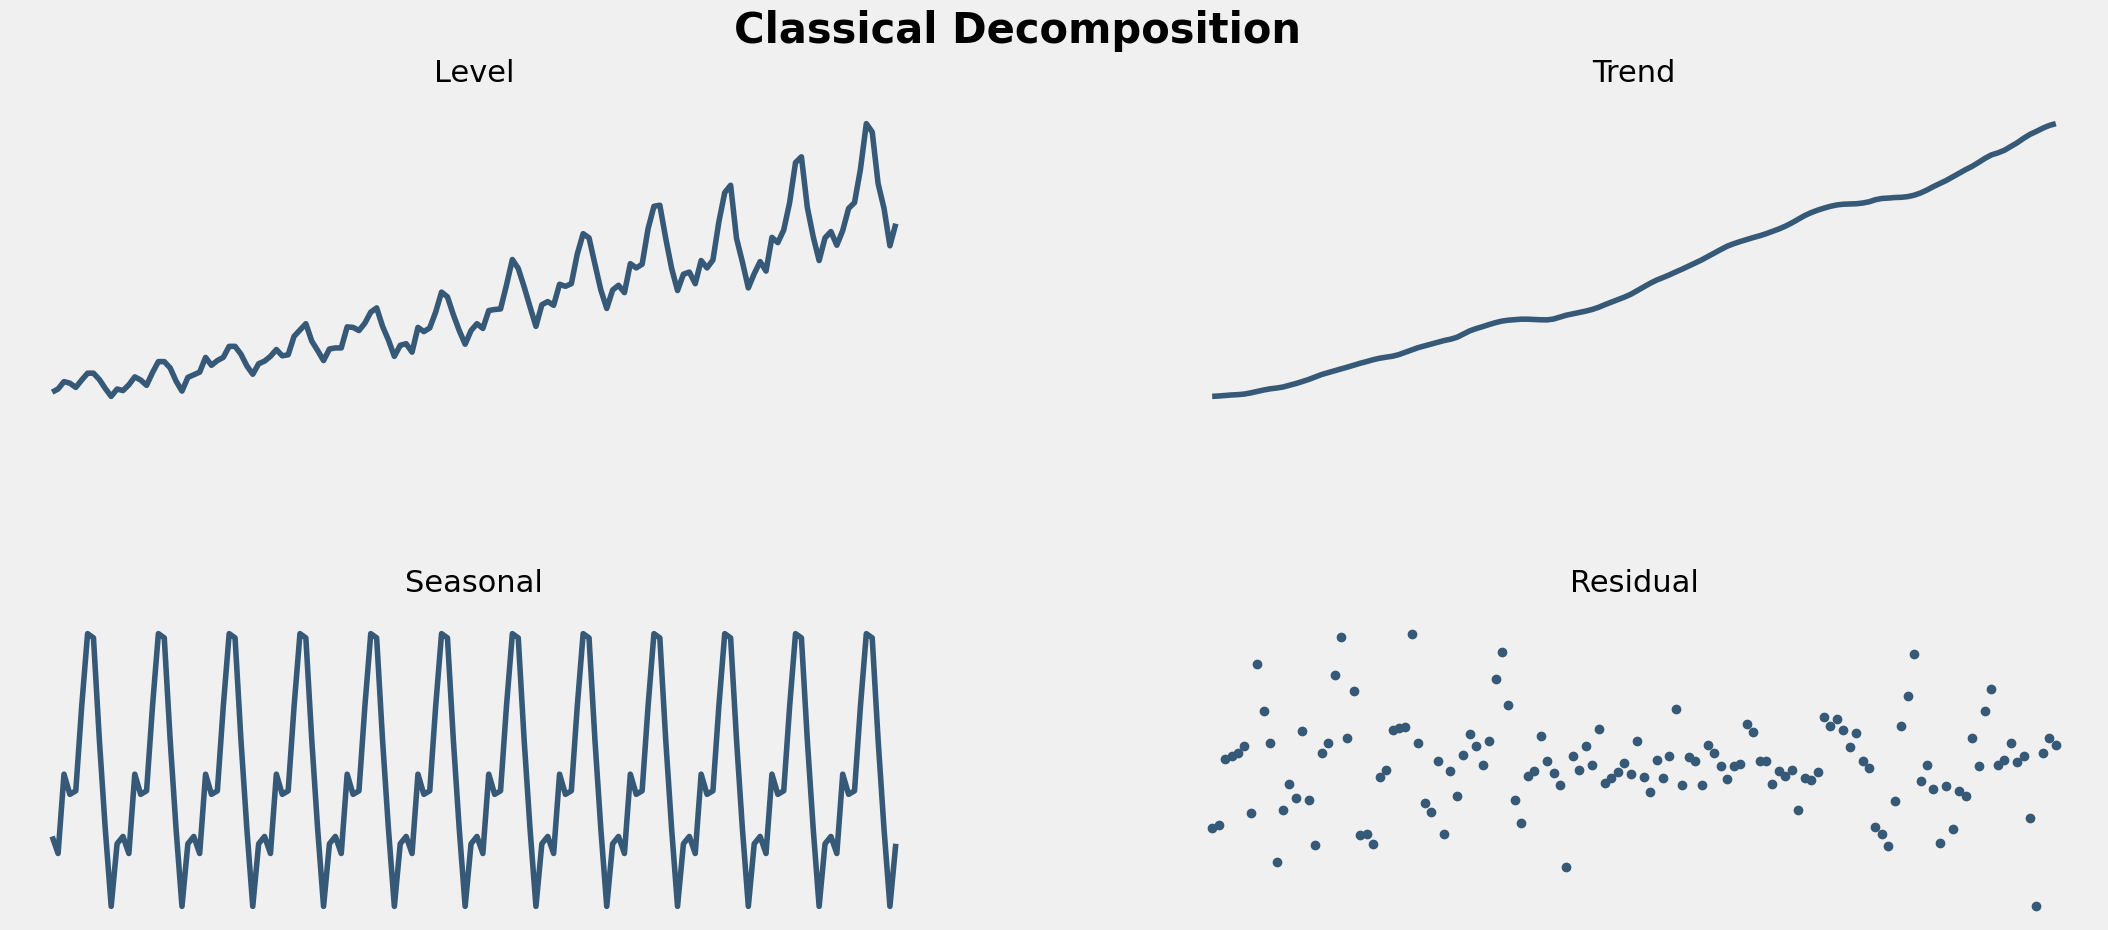

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(24, 10))

ax.ravel()[0].plot(result.observed, color='#365977')
ax.ravel()[0].set_title('Level', pad=20, fontsize=22)
ax.ravel()[0].set_xticks([])
ax.ravel()[0].set_yticks([])

ax.ravel()[1].plot(result.trend, color='#365977')
ax.ravel()[1].set_title('Trend', pad=20, fontsize=22)
ax.ravel()[1].set_xticks([])
ax.ravel()[1].set_yticks([])

ax.ravel()[2].plot(result.seasonal, color='#365977')
ax.ravel()[2].set_title('Seasonal', pad=20, fontsize=22)
ax.ravel()[2].set_xticks([])
ax.ravel()[2].set_yticks([])

ax.ravel()[3].plot(result.resid, color='#365977', marker="o", linestyle="none")
ax.ravel()[3].set_title('Residual', pad=20, fontsize=22)
ax.ravel()[3].set_xticks([])
ax.ravel()[3].set_yticks([])

plt.suptitle('Classical Decomposition', fontsize=30, fontweight='bold')
plt.subplots_adjust(hspace = 0.7, wspace=.25)
plt.show()

## Some of the problems with classical decomposition:

<hr>

- The estimate of the trend-cycle is unavailable for the first few and last few observations.

- The trend-cycle estimate tends to over-smooth rapid rises and falls in the data.

- Classical decomposition methods assume that the seasonal component repeats from year to year. i.e this methods is unable to capture the seasonal that change over time.

<div class="alert alert-danger"> <b>Look at the level plot (upper left), this data has a multiplicative seasonality<br><br>But this method is not able to capture this seasonality (lower left plot)</b> </div>

Source: [Forecasting: Principles and Practice](https://otexts.com/fpp3/classical-decomposition.html)

In [11]:
## --------------------------------------------------------------------------------------------------------------------- ##

## STL decomposition

<hr>

STL is an acronym for `Seasonal and Trend decomposition using Loess`

<br>

It has several advantages over classical decomposition:

- Able to capture the seasonal that change over time

- It can handles any type of seasonality.

- The user can control the rate of change of the seasonal component.

- It is robust to outliers.

source: [medium](https://towardsdatascience.com/different-types-of-time-series-decomposition-396c09f92693)

<div class="alert alert-warning"> <b>Remember, STL only capture one single seasonal component</b> </div>

In [12]:
from statsmodels.tsa.seasonal import STL

# Setting robust uses a data-dependent weighting function that re-weights data when estimating the LOESS (and so is using LOWESS).
# Using robust estimation allows the model to tolerate larger errors that are visible on the bottom plot.

# m=12, for monthly data with a yearly seasonality pattern
# m=7, for daily data with a weekly seasonality pattern
result = STL(df, robust = True, period=12).fit()

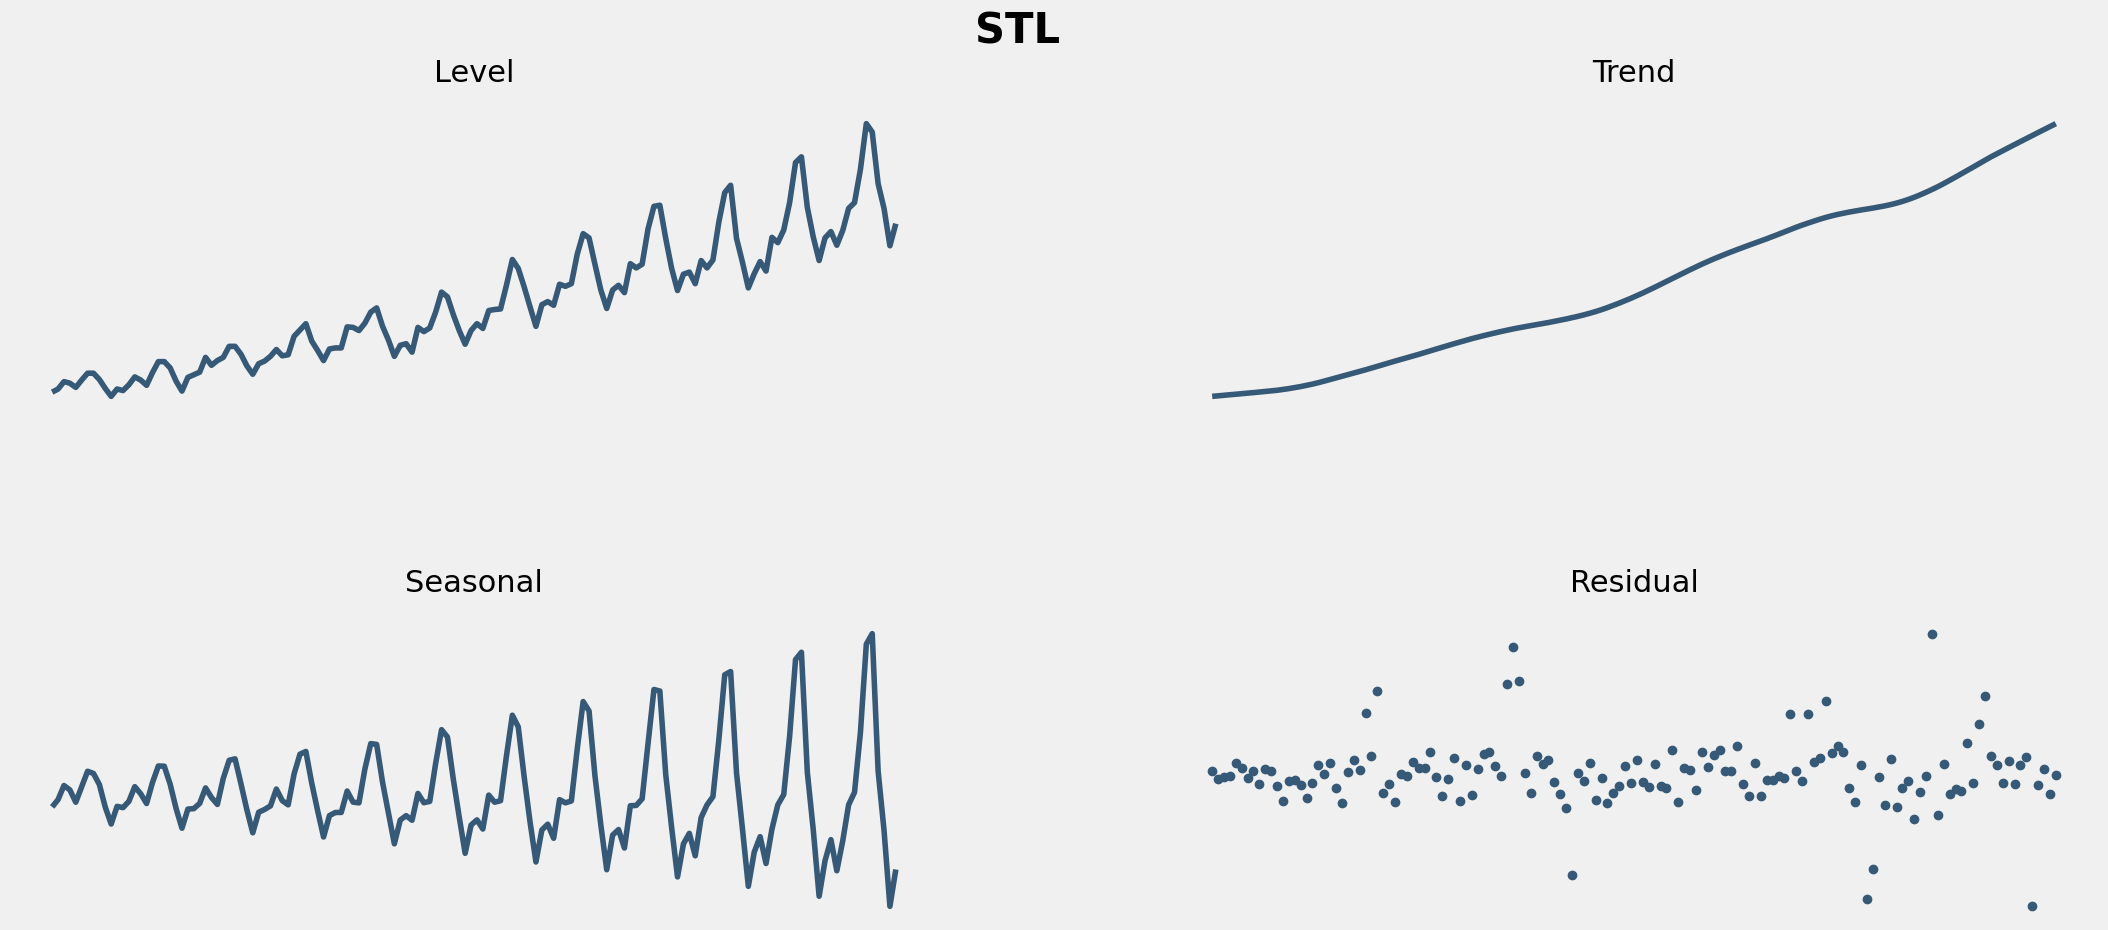

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(24, 10))

ax.ravel()[0].plot(result.observed, color='#365977')
ax.ravel()[0].set_title('Level', pad=20, fontsize=22)
ax.ravel()[0].set_xticks([])
ax.ravel()[0].set_yticks([])

ax.ravel()[1].plot(result.trend, color='#365977')
ax.ravel()[1].set_title('Trend', pad=20, fontsize=22)
ax.ravel()[1].set_xticks([])
ax.ravel()[1].set_yticks([])

ax.ravel()[2].plot(result.seasonal, color='#365977')
ax.ravel()[2].set_title('Seasonal', pad=20, fontsize=22)
ax.ravel()[2].set_xticks([])
ax.ravel()[2].set_yticks([])

ax.ravel()[3].plot(result.resid, color='#365977', marker="o", linestyle="none")
ax.ravel()[3].set_title('Residual', pad=20, fontsize=22)
ax.ravel()[3].set_xticks([])
ax.ravel()[3].set_yticks([])

plt.suptitle('STL', fontsize=30, fontweight='bold')
plt.subplots_adjust(hspace = 0.7, wspace=.25)
plt.show()

<div class="alert alert-success"> <b>Look at the Seasonal plot (lower left)<br><br>This model can capture a multiplicative seasonality, which classical methods cannot do</b> </div>

In [14]:
## --------------------------------------------------------------------------------------------------------------------- ##

<b>If you’d like to seasonally adjust your data,</b>

<b>just subtract the raw data with the seasonal component.</b>

In [15]:
df['seasonally_adjusted'] = df['num_passengers'] - result.seasonal

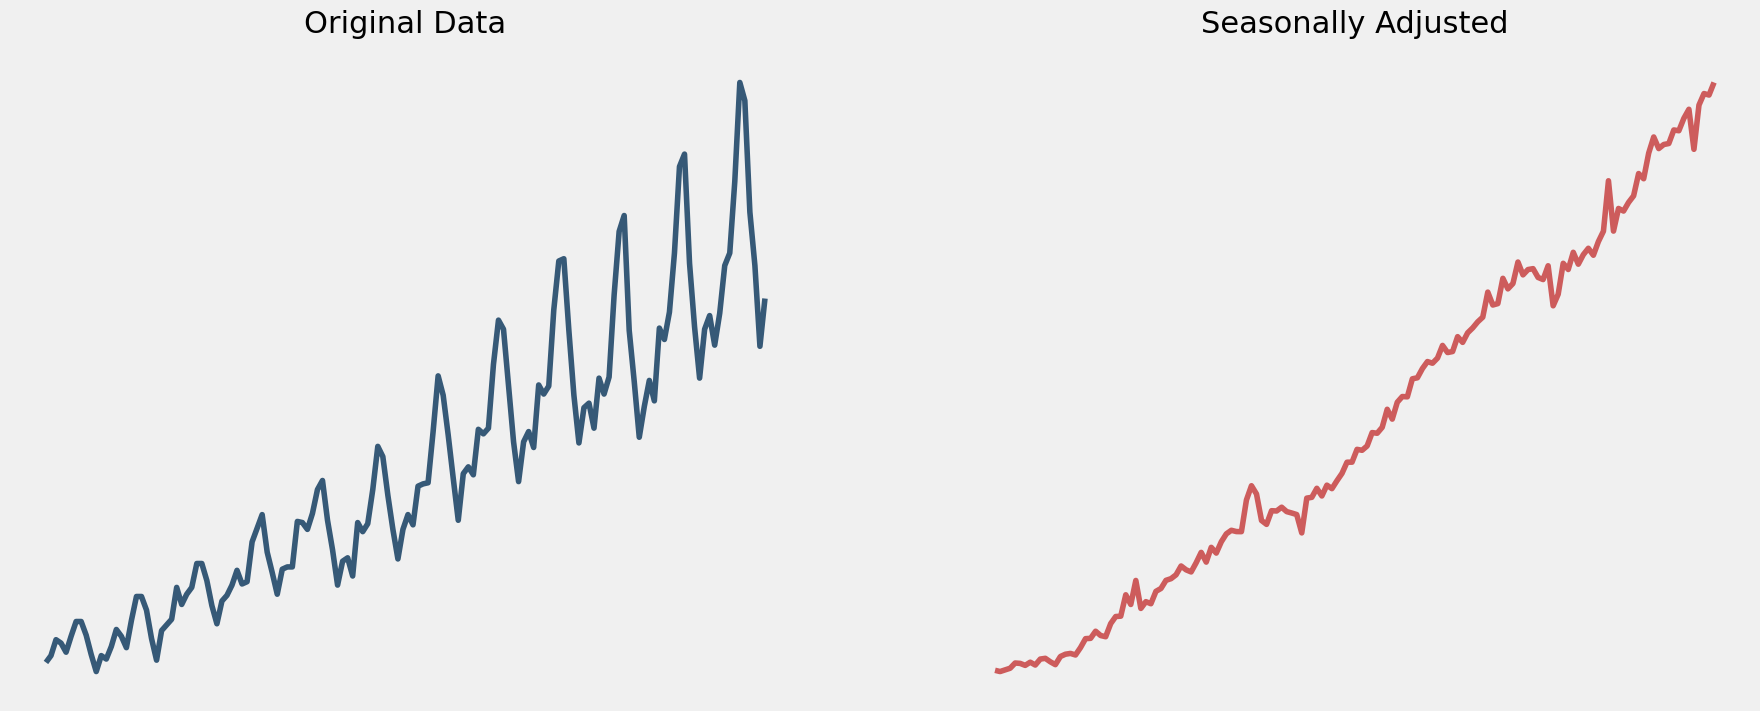

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

ax.ravel()[0].plot(df['num_passengers'], color='#365977')
ax.ravel()[0].set_title('Original Data', pad=15, fontsize=22)
ax.ravel()[0].set_xticks([])
ax.ravel()[0].set_yticks([])
ax.ravel()[0].tick_params(axis='x', which='major', labelsize=18, pad=10)

ax.ravel()[1].plot(df['seasonally_adjusted'], color='indianred')
ax.ravel()[1].set_title('Seasonally Adjusted', pad=15, fontsize=22)
ax.ravel()[1].set_xticks([])
ax.ravel()[1].set_yticks([])
ax.ravel()[1].tick_params(axis='x', which='major', labelsize=18, pad=10)

plt.show()

In [17]:
## --------------------------------------------------------------------------------------------------------------------- ##

# Forecasting

## Combine ARIMA with STL to forecast num future passengers



In [18]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.forecasting.stl import STLForecast
from sklearn.metrics import mean_absolute_percentage_error

df.index = pd.to_datetime(df.index)

train = df.iloc[:-12] # exclude last year in data
test = df.iloc[-12:] # only last year data

In [19]:
warnings.filterwarnings('ignore')

## The STL approach or TBATS model is preferable when the seasonality changes over time.
# https://www.statsmodels.org/dev/examples/notebooks/generated/stl_decomposition.html
stlf = STLForecast(train['num_passengers'], ARIMA, model_kwargs=dict(order=(1, 1, 0), trend="t"), period=12)
stlf_res = stlf.fit()

# forecast for the next 12 months num_passengers
forecast = stlf_res.forecast(12)

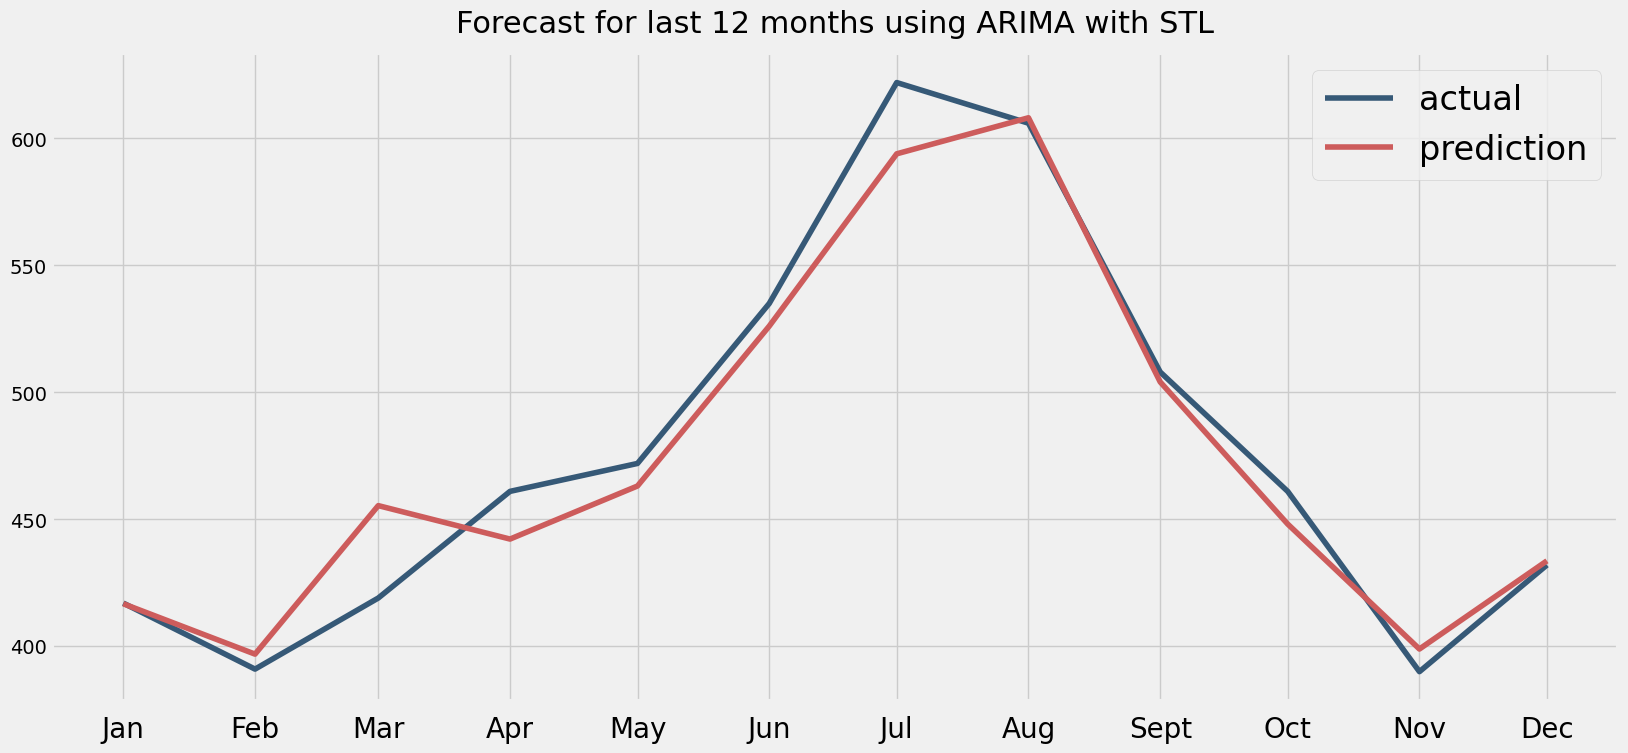

In [20]:
fig = plt.figure(figsize=(18, 8))

plt.plot(test['num_passengers'], color='#365977', label='actual')
plt.plot(forecast, color='indianred', label='prediction')

plt.title('Forecast for last 12 months using ARIMA with STL', pad=15, fontsize=22)
plt.xticks(['1960-01-01', '1960-02-01', '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01', '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01', '1960-11-01', '1960-12-01'], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'])
plt.tick_params(axis='x', which='major', labelsize=20, pad=10)
plt.legend(fontsize='xx-large')
plt.show()

In [21]:
## --------------------------------------------------------------------------------------------------------------------- ##

## Seasonal ARIMA (SARIMA)

<hr>

The *pure* seasonal autoregressive and moving average model, $ARMA(P,Q)$, take the from

$$\Phi_P(B^s)z_t=\Theta_Q(B^s)\epsilon_t$$ 

where 

$$\Phi_P(B^2)=1 - \Phi_1 B^s - \Phi_2 B^{2s} - \cdots - \Phi_P B^{Ps}$$

and 

$$\Theta_Q(B^2)=1 - \Theta_1 B^s - \Theta_2 B^{2s} - \cdots - \Theta_Q B^{Qs}$$

<br>

are the **seasonal AutoRegressive operator** and the **seasonal Moving Average operator** of orders $P$ and $Q$ with **seasonal period s**.

In [22]:
## --------------------------------------------------------------------------------------------------------------------- ##

**Example:**

A first-order seasonal autoregressive moving average series over months (or $SARIMA(1,0,1,12)$) can be expressed as

$$ z_t = \Phi z_{t-12} + \epsilon_t + \Theta \epsilon_{t-12} $$

or

$$ (1 - \Phi B^{12})z_t = (1 + \Theta B^{12})\epsilon_t $$

<br>

In other words, this model capture the relationship between $z_t$ and its lags at the multiple of the yearly seasonal period $s=12$ months.

In [23]:
## --------------------------------------------------------------------------------------------------------------------- ##

**Note that we use (p, d, q) to denote the orders for the non-seasonal components of the ARIMA models and (P, D, Q, s) to denote the orders for the seasonal components of the ARIMA model.**

<br>

The general formulation of the **Multiplicative Seasonal Autoregressive Integrated Moving Average (SARIMA)** model takes the following form:

$$ \phi_p(B) \Phi_P(B^s) \bigtriangledown^d \bigtriangledown^D_s z_t = \theta_q(B) \Theta_Q(B^s) \epsilon_t $$ 

<br>

where

- $\epsilon_t$ is a white noise process

- $\phi_p(B)$ and $\theta_q(B)$ are non-seasonal autoregressive and moving average lag polynomials

- $\Phi_P(B^s)$ and $\Theta_Q(B^s)$ are seasonal autoregressive and moving average lag polynomials

- $\bigtriangledown^d \equiv (1-B)^d$ and $\bigtriangledown^D_s \equiv (1-B^s)^D$ are the difference (or integrated) components

<br>

Therefore, the general model is denoted as $\mathbf{ARIMA(p,d,q)\times(P,D,Q)_s}$

source: [Jeffrey Yau: Applied Time Series Econometrics in Python and R](https://www.youtube.com/watch?v=tJ-O3hk1vRw)

In [24]:
import pmdarima as pm

# https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html
SARIMA_model = pm.auto_arima(train['num_passengers'],
                             # test='adf', # default=’kpss’
                             start_p=1,
                             start_q=1,
                             d=None, # if None (by default), the value will automatically be selected based on the results of the test
                             max_p=3, 
                             max_q=3, 
                             
                             m=12, # the frequncy of the cycle, (if m=1 (default), seasonal will be set to FALSE automatically)
                             seasonal=True, #set to seasonal
                             start_P=0, 
                             D=None, # The order of the seasonal differencing. If None (by default, the value will automatically be selected based on the results of the seasonal_test
                             
                             trace=False, # train logs
                             error_action='ignore',  # warn
                             random_state=9171,
                             n_fits=20, # the number of ARIMA models to be fit, default=10
)

In [25]:
print('Best Model:')
print(f'SARIMA{SARIMA_model.order} {SARIMA_model.seasonal_order}')
print('\nAIC:', round(SARIMA_model.aic(), 2))

Best Model:
SARIMA(3, 0, 0) (0, 1, 0, 12)

AIC: 905.69


In [26]:
print(SARIMA_model.summary().tables[1])
print(SARIMA_model.summary().tables[2])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.5341      2.007      2.757      0.006       1.600       9.468
ar.L1          0.7049      0.095      7.393      0.000       0.518       0.892
ar.L2          0.2574      0.131      1.968      0.049       0.001       0.514
ar.L3         -0.1434      0.107     -1.338      0.181      -0.354       0.067
sigma2       101.0969     12.818      7.887      0.000      75.974     126.220
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.83
Prob(Q):                              0.96   Prob(JB):                         0.24
Heteroskedasticity (H):               1.41   Skew:                            -0.14
Prob(H) (two-sided):                  0.29   Kurtosis:                         3.70


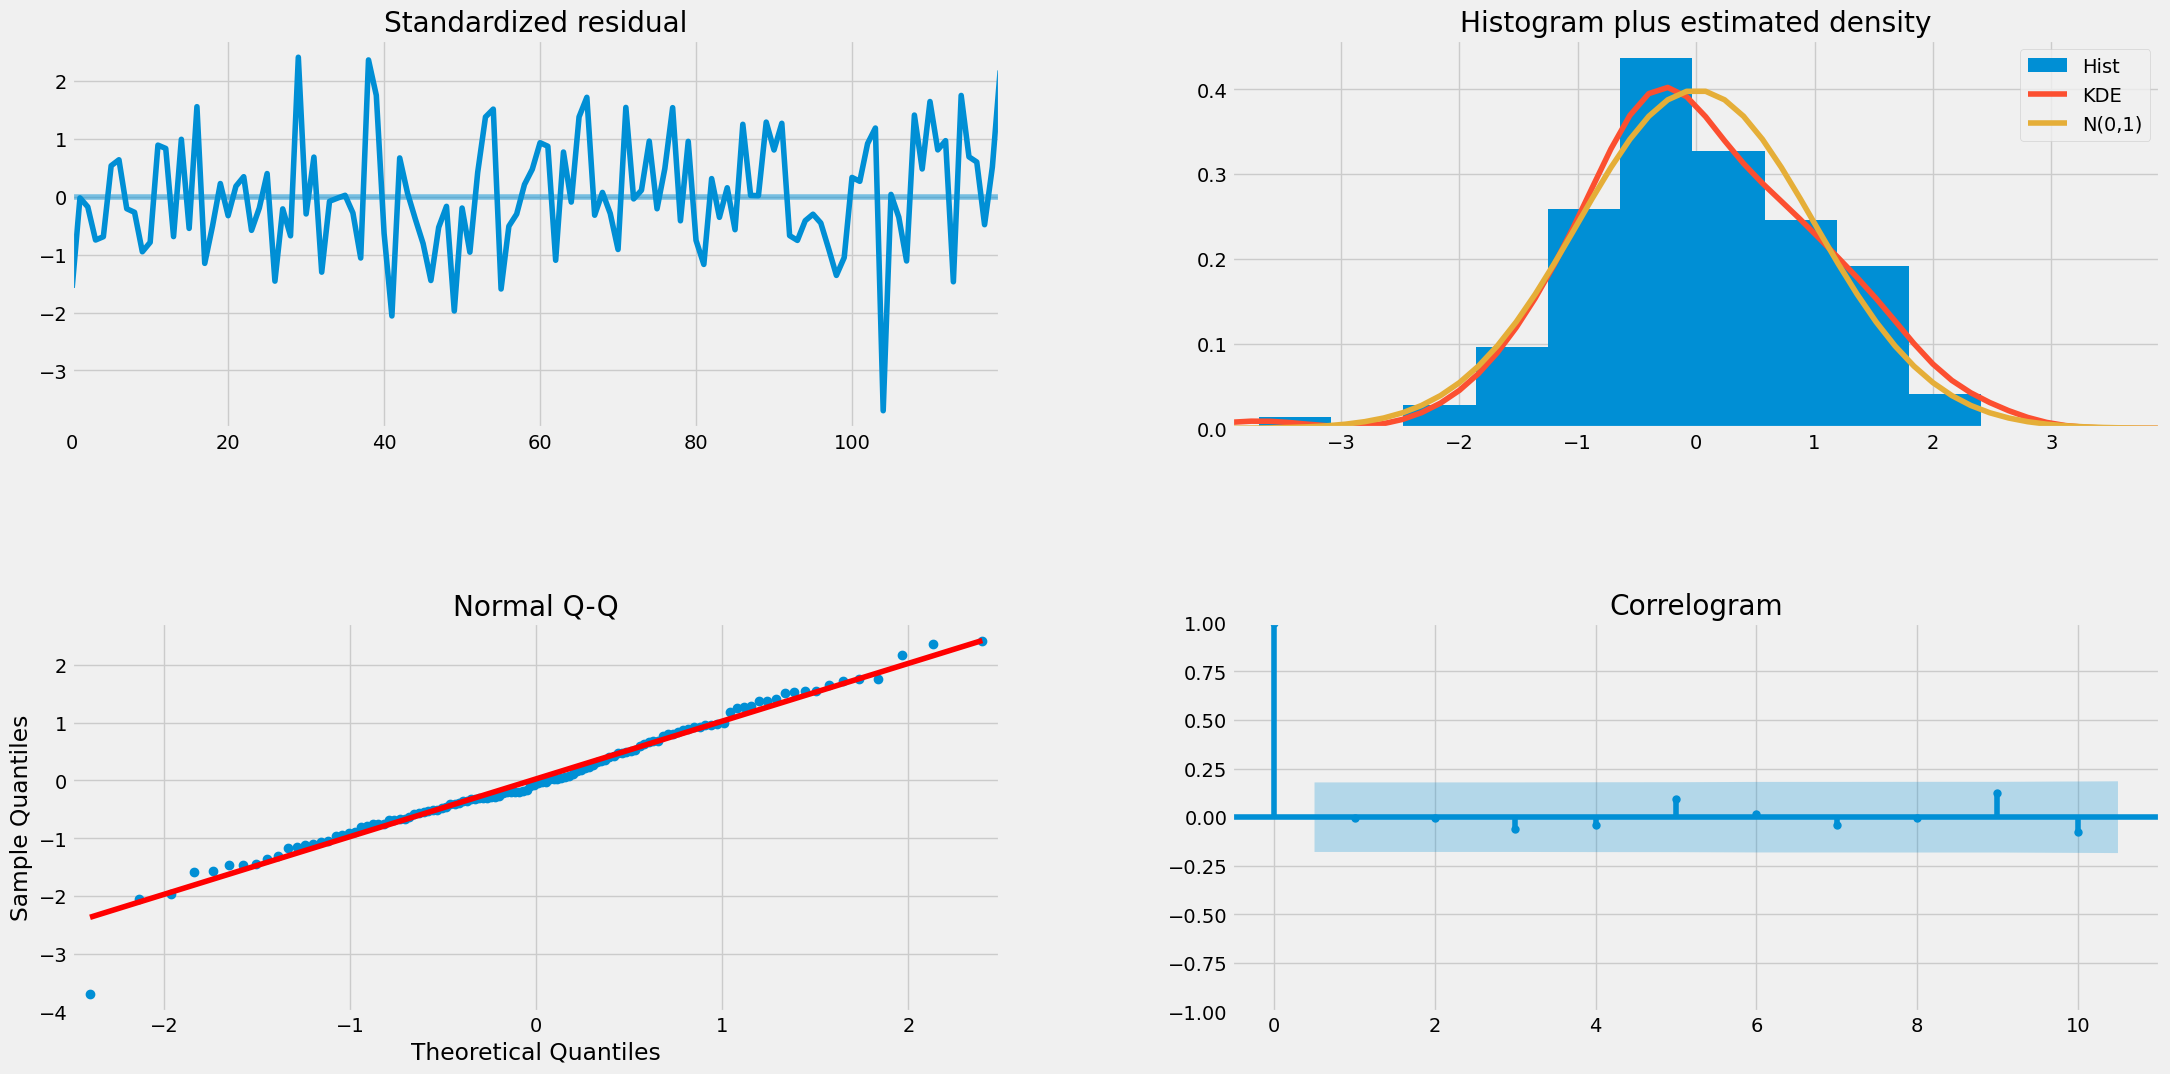

In [27]:
# The plot_diagnostics function associated with the estimated result object produce a few plots that allow us 
# to examine the distribution and correlation of the estimated residuals

# Residuals of a well-specified ARIMA model should mimic Gaussian white noises
# i.e, the residuals should be uncorrelated and distributed approximated normally with mean zero and variance 𝑛−1

SARIMA_model.plot_diagnostics(figsize=(24, 12))
plt.subplots_adjust(hspace = 0.5, wspace=.25)
plt.show()

## Residual Analysis: 

<hr>

- The residuals have no trend and a fairly constant variance over time, just like white noise.

- The distribution of residuals is very close to a normal distribution. (top right plot)

- This is further supported by the Q-Q plot on the bottom left that shows a fairly straight line.

- The correlogram shows no significant coefficients after lag 0, just like white noise.

In [28]:
sarima_forecast = SARIMA_model.predict(n_periods=12)
sarima_forecast = pd.Series(sarima_forecast, index=test.index)

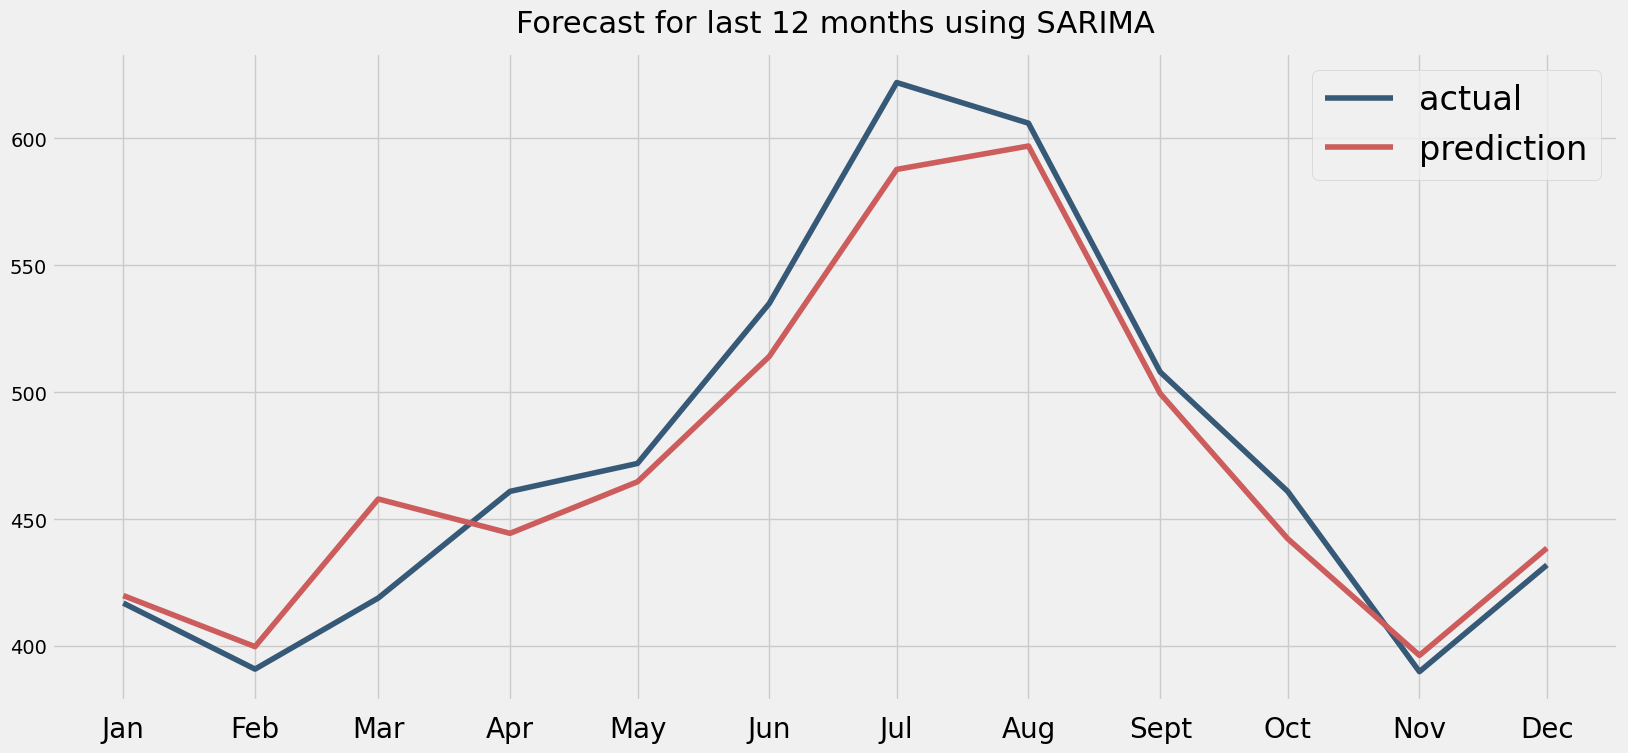

In [29]:
fig = plt.figure(figsize=(18, 8))

plt.plot(test['num_passengers'], color='#365977', label='actual')
plt.plot(sarima_forecast, color='indianred', label='prediction')

plt.title('Forecast for last 12 months using SARIMA', pad=15, fontsize=22)
plt.xticks(['1960-01-01', '1960-02-01', '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01', '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01', '1960-11-01', '1960-12-01'], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'])
plt.tick_params(axis='x', which='major', labelsize=20, pad=10)
plt.legend(fontsize='xx-large')
plt.show()

In [30]:
## --------------------------------------------------------------------------------------------------------------------- ##

# SARIMAX

<hr>

- We can use <b>exogenous variables</b> in our forecast

- Exogenous variables means other variables (feature) in our dataset or external data

- Some real-world examples of exogenous variables: gold price, oil price, outdoor temperature, exchange rate

In [31]:
# add exogenous variable
train['is_highseason'] = ((train.index.month == 7) | (train.index.month == 8)).astype(int)
test['is_highseason'] = ((test.index.month == 7) | (test.index.month == 8)).astype(int)

In [32]:
import pmdarima as pm

# https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html
SARIMAX_model = pm.auto_arima(train['num_passengers'],
                              X=train[['is_highseason']], # don't use exogenous=
                              test='adf', # default=’kpss’
                              start_p=1,
                              start_q=1,
                              d=None, # if None (by default), the value will automatically be selected based on the results of the test
                              max_p=5, 
                              max_q=5, 
                             
                              m=12, # the frequncy of the cycle, (if m=1 (default), seasonal will be set to FALSE automatically)
                              seasonal=True, #set to seasonal
                              start_P=0, 
                              D=None, # The order of the seasonal differencing. If None (by default, the value will automatically be selected based on the results of the seasonal_test
                              max_P=5,
                              max_D=5,
                              max_Q=5,
                              
                              trace=False, # train logs
                              error_action='ignore',  # warn
                              random_state=20,
                              n_fits=50, # the number of ARIMA models to be fit, default=10
)

In [33]:
print('Best Model:')
print(f'SARIMAX{SARIMAX_model.order} {SARIMAX_model.seasonal_order}')
print('\nAIC:', round(SARIMAX_model.aic(), 2))

Best Model:
SARIMAX(1, 0, 0) (1, 0, 1, 12)

AIC: 1035.59


In [34]:
print(SARIMAX_model.summary().tables[1])
print(SARIMAX_model.summary().tables[2])

                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
is_highseason    47.4612     18.313      2.592      0.010      11.568      83.354
ar.L1             0.9727      0.018     53.294      0.000       0.937       1.008
ar.S.L12          0.9488      0.033     28.654      0.000       0.884       1.014
ma.S.L12         -0.0913      0.097     -0.938      0.348      -0.282       0.099
sigma2          109.8656     13.135      8.364      0.000      84.122     135.610
Ljung-Box (L1) (Q):                   4.93   Jarque-Bera (JB):                 4.01
Prob(Q):                              0.03   Prob(JB):                         0.13
Heteroskedasticity (H):               2.09   Skew:                            -0.05
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.85


In [35]:
sarimax_forecast = SARIMAX_model.predict(n_periods=12, X=test[['is_highseason']]) # # don't use exogenous=
sarimax_forecast = pd.Series(sarimax_forecast, index=test.index)

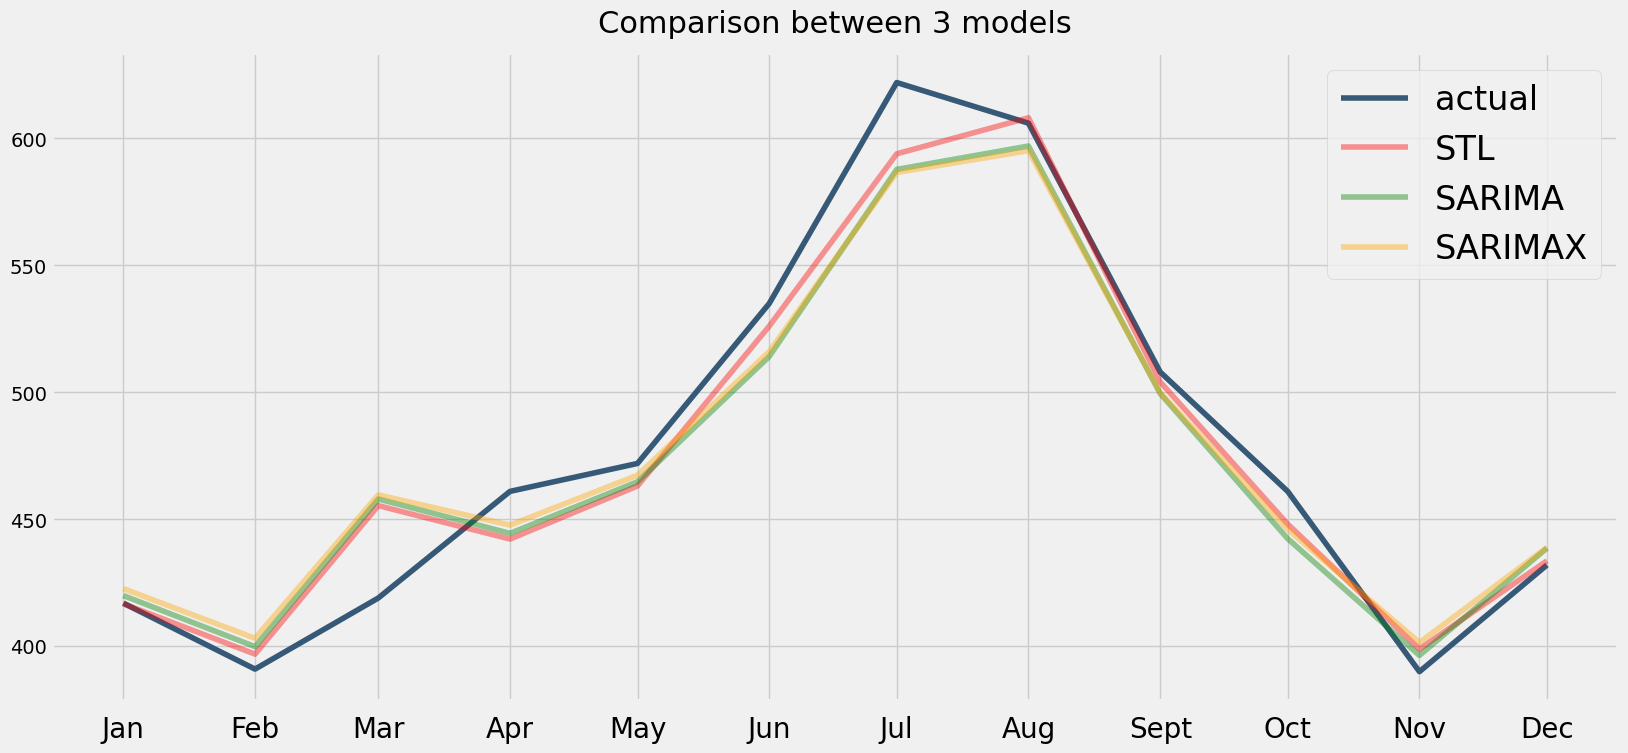

In [36]:
fig = plt.figure(figsize=(18, 8))

plt.plot(test['num_passengers'], color='#365977', label='actual')

plt.plot(forecast, color='red', label='STL', alpha=0.4)
plt.plot(sarima_forecast, color='green', label='SARIMA', alpha=0.4)
plt.plot(sarimax_forecast, color='orange', label='SARIMAX', alpha=0.4)

plt.title('Comparison between 3 models', pad=15, fontsize=22)
plt.xticks(['1960-01-01', '1960-02-01', '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01', '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01', '1960-11-01', '1960-12-01'], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'])
plt.tick_params(axis='x', which='major', labelsize=20, pad=10)
plt.legend(fontsize='xx-large')
plt.show()

<div class="alert alert-success"> <b>Note that all the forecast results are lower than the actual<br><br>i.e: under-forecast</b> </div>

In [37]:
## --------------------------------------------------------------------------------------------------------------------- ##

# Holt-Winters Forecasting

<hr>

The Holt-Winters method — also known as <b>triple exponential smoothing</b> — is used for forecasting time series data that exhibits both a <b>trend</b> and a <b>seasonal</b> variation.

This method is a combination of 3 other much simpler components, all of which are smoothing methods:

- <b>Simple Exponential Smoothing (SES)</b>: Simple exponential smoothing assumes that the time series has no change in level. Thus, it can not be used with series that contain trend, seasonality, or both.

- <b>Holt’s Exponential Smoothing (HES)</b>: Holt’s exponential smoothing is one step above simple exponential smoothing, as it allows the time series data to have a trend component. Holt’s exponential smoothing is still incapable of cope with seasonal data.

- <b>Winter’s Exponential Smoothing (WES)</b>: Winter’s exponential smoothing is an extension to Holt’s exponential smoothing that finally allows for the inclusion of seasonality. Winter’s exponential smoothing is what is referred to as the Holt-Winters method.

In [38]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Set the value of Alpha and define m (Time Period)
m = 12
alpha = 1 / (2 * m)

<img src="https://miro.medium.com/max/1400/1*LkenE8m9mWLscy2VIOgzNw.png" alt="holt-winters" width="600" align="left">

In [39]:
holt_winters_atms = ExponentialSmoothing(train['num_passengers'], trend='add', seasonal='mul', seasonal_periods=12).fit()

hw_atms_pred = holt_winters_atms.forecast(12)

# print(holt_winters_atms.summary())

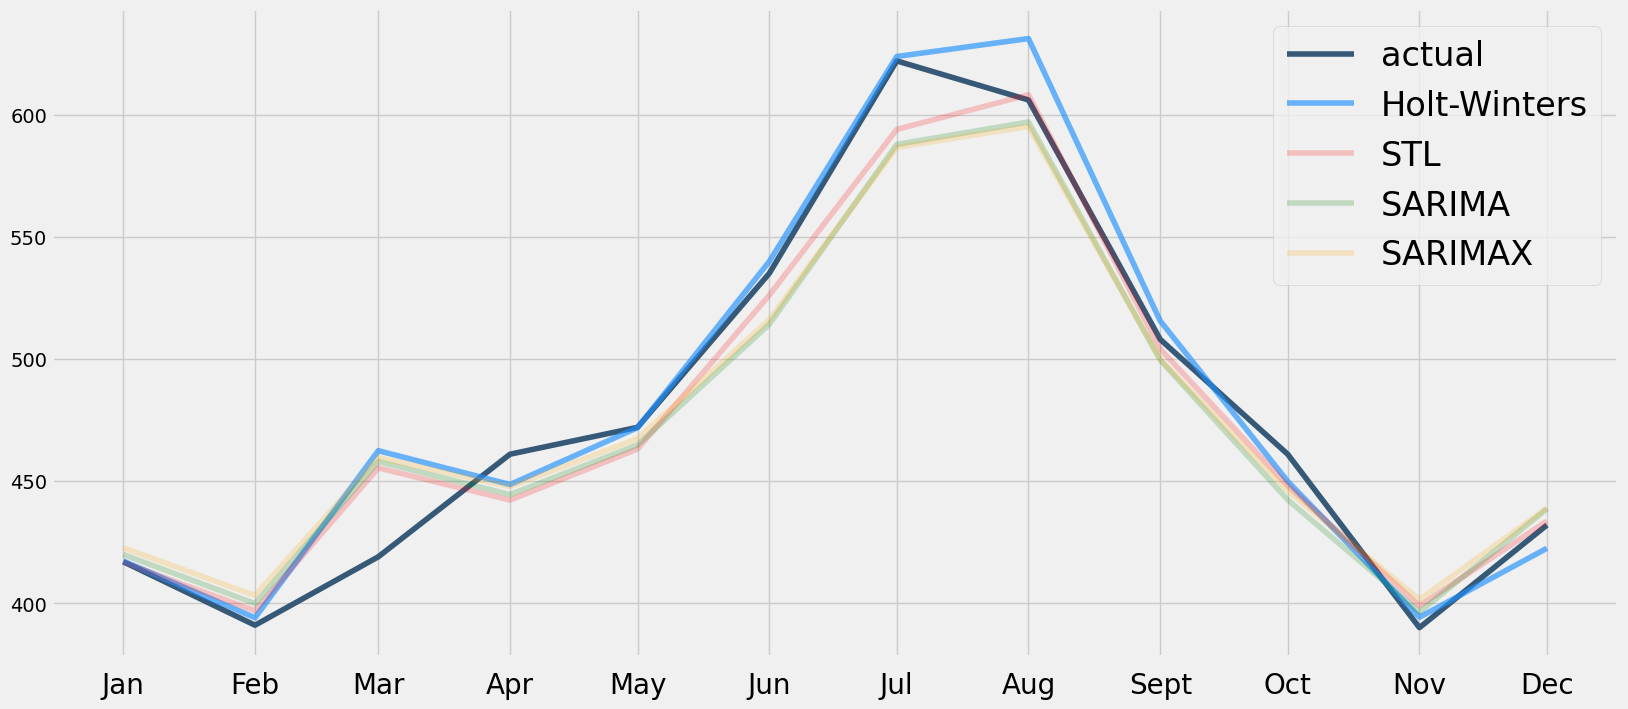

In [40]:
fig = plt.figure(figsize=(18, 8))

plt.plot(test['num_passengers'], color='#365977', label='actual')
plt.plot(hw_atms_pred, color='dodgerblue', label='Holt-Winters', alpha=0.65)

# STL, SARIMA, SARIMAX
plt.plot(forecast, color='red', label='STL', alpha=0.2)
plt.plot(sarima_forecast, color='green', label='SARIMA', alpha=0.2)
plt.plot(sarimax_forecast, color='orange', label='SARIMAX', alpha=0.2)

# plt.title('Forecast for last 12 months using Holt-Winters', pad=15, fontsize=22)
plt.xticks(['1960-01-01', '1960-02-01', '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01', '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01', '1960-11-01', '1960-12-01'], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'])
plt.tick_params(axis='x', which='major', labelsize=20, pad=10)
plt.legend(fontsize='xx-large')
plt.show()

<div class="alert alert-success"> <b>In contrast with STL, SARIMA and SARIMAX<br><br>Holt-Winter forecast results is higher than the actual; i.e: over-forecast</b> </div>

In [41]:
## --------------------------------------------------------------------------------------------------------------------- ##

## Mean Absolute Percentage Error (MAPE)

<hr>

<img src="https://miro.medium.com/max/887/1*wmzR0nrtlp7k6SfNKEMyqw@2x.png" alt="mape" width="400" align="left">

In [42]:
arima_stl_mape_score = mean_absolute_percentage_error(test['num_passengers'], forecast) # the lower the MAPE, better fit is the model.
sarima_mape_score = mean_absolute_percentage_error(test['num_passengers'], sarima_forecast)
sarimax_mape_score = mean_absolute_percentage_error(test['num_passengers'], sarimax_forecast)
holt_winters_mape_score = mean_absolute_percentage_error(test['num_passengers'], hw_atms_pred)

print('MAPE Score for HOLT-WINTERS:', round(holt_winters_mape_score, 3))
print('MAPE Score for STL-ARIMA:', round(arima_stl_mape_score, 3))
print('MAPE Score for SARIMA:', round(sarima_mape_score, 3))
print('MAPE Score for SARIMAX:', round(sarimax_mape_score, 3))

MAPE Score for HOLT-WINTERS: 0.022
MAPE Score for STL-ARIMA: 0.024
MAPE Score for SARIMA: 0.031
MAPE Score for SARIMAX: 0.032


<div class="alert alert-info"> <b>MAPE puts a heavier penalty on forecasts that exceed the actual than those that are less than the actual<br><br>As a result, MAPE will favor models that under-forecast rather than over-forecast.</b> </div>

## No Free Lunch Theorem

<hr>

There is no single best machine learning algorithm for predictive modeling

If one algorithm performs better than another algorithm on one class of problems, then it will perform worse on another class of problems

<div class="alert alert-success"> <b>We need to try many different types of models, to cover the wide variety of data that occurs in the real world</b> </div>

In [43]:
##################################################################################################################
##########################################  To Be Continued  #####################################################
##################################################################################################################

## Reference

- [A Thorough Introduction to Holt-Winters Forecasting](https://medium.com/analytics-vidhya/a-thorough-introduction-to-holt-winters-forecasting-c21810b8c0e6)

- [Holt-Winters Exponential Smoothing](https://timeseriesreasoning.com/contents/holt-winters-exponential-smoothing/)